### Можно выполнить этот ноутбук в colab, чтобы проверить все ячейки и посмотреть анимации. Так же анимации сохранил отдельно в папку

In [ ]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life

In [2]:
def animate(i):
    im.set_data(data[i].reshape((field_size, field_size)))
    return(im,)

## Под этим спойлером код 1 задания

In [3]:
%%writefile meet_the_comp.c
#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>


void print_result(int* arr, int N)
{
    printf("name%d", arr[0]);
    for (int i = 1; i < N; ++i)
        printf(" -> name%d", arr[i]);
    printf("\n");
}

void current_state(int* state, int psize)
{
    int* done_processes = state;
    int* remaining_processes = state + psize;

    state[2 * psize] = 0;
    state[2 * psize + 1] = psize;

    for (int i = 0; i < psize; ++i)
    {
        remaining_processes[i] = i;
    }
}

int state_next(int* state, int prank, int psize)
{
    int* done_processes = state;
    int* remaining_processes = state + psize;

    int n_done = state[2 * psize];
    int n_remaining = state[2 * psize + 1];

    done_processes[n_done] = prank;
    state[2 * psize] = ++n_done;

    int i;
    for (i = 0; i < n_remaining; ++i)
    {
        if (prank == remaining_processes[i])
        {
            break;
        }
    }

    remaining_processes[i] = remaining_processes[n_remaining - 1];
    state[2 * psize + 1] = --n_remaining;

    int send_to_rank = -1;
    if (n_remaining > 0)
        send_to_rank = remaining_processes[rand() % n_remaining];

    return send_to_rank;
}

int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int psize;
    MPI_Comm_size(MPI_COMM_WORLD, &psize);

    int prank;
    MPI_Comm_rank(MPI_COMM_WORLD, &prank);

    int* state = (int*)malloc((2 * psize + 2) * sizeof(int));
    current_state(state, psize);

    if (prank == 0)
    {
        int send_to = state_next(state, prank, psize);
        MPI_Ssend(state, 2 * psize + 2, MPI_INT, send_to, 99, MPI_COMM_WORLD);
    }
    else
    {
        MPI_Recv(state, 2 * psize + 2, MPI_INT, MPI_ANY_SOURCE, 99, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        int send_to = state_next(state, prank, psize);

        if (send_to > 0)
        {
            MPI_Ssend(state, 2 * psize + 2, MPI_INT, send_to, 99, MPI_COMM_WORLD);
        }
        else
        {
            print_result(state, psize);
        }
    }

    free(state);
    MPI_Finalize();
    return 0;
}

Overwriting meet_the_comp.c


## Пример выполнения кода

In [4]:
!mpicc meet_the_comp.c -o meet_the_comp

In [5]:
!mpirun -n 8 --allow-run-as-root meet_the_comp

name0 -> name1 -> name6 -> name3 -> name4 -> name5 -> name2 -> name7


## Под этим спойлером код 2 задания

In [6]:
%%writefile cellular_automata.c
#include <mpi.h>
#include <stdio.h>
#include <assert.h>
#include <stdlib.h>


#define ind(i, j) (i + l->nx) % l->nx + ((j + l->ny) % l->ny) * l->nx

typedef struct
{
    int nx;
    int ny;

    int* u0;
    int* u1;
    int steps;
    int save_steps;

    int psize, prank;
    int start_col, end_col;
} life_t;

MPI_Datatype VERTICAL_BLOCK;
MPI_Datatype LAST_VERTICAL_BLOCK;
MPI_Datatype COLUMN;

void life_init(const char *path, life_t *l);
void decomposition(const int prank, const int psize, const int nx, int* start_col, int* end_col);
void life_step(life_t* l);
void life_collect(life_t* l);
void life_exchange(life_t* l);
void life_free(life_t* l);
void life_save_vtk(const char* path, life_t* l);

void life_init(const char* path, life_t* l)
{
    FILE* fd = fopen(path, "r");

    assert(fd);
    assert(fscanf(fd, "%d\n", &l->steps));
    assert(fscanf(fd, "%d\n", &l->save_steps));
    assert(fscanf(fd, "%d %d\n", &l->nx, &l->ny));

    l->u0 = (int*)calloc(l->nx * l->ny, sizeof(int));
    l->u1 = (int*)calloc(l->nx * l->ny, sizeof(int));

    int i, j, r, cnt;
    cnt = 0;
    while ((r = fscanf(fd, "%d %d\n", &i, &j)) != EOF) {
        l->u0[ind(i, j)] = 1;
        cnt++;
    }
    fclose(fd);

    MPI_Comm_size(MPI_COMM_WORLD, &(l->psize));
    MPI_Comm_rank(MPI_COMM_WORLD, &(l->prank));
    decomposition(l->prank, l->psize, l->nx, &(l->start_col), &(l->end_col));
}

void decomposition(
    const int prank,
    const int psize,
    const int nx,
    int* start_col,
    int* end_col
)
{
    int columns_per_process = nx / psize;
    *start_col = columns_per_process * prank;
    *end_col = *start_col + columns_per_process;
    if (prank == psize - 1)
        *end_col = nx;
}

void life_collect(life_t* l)
{
    if (l->prank == 0)
    {
        int start_col, end_col;
        for (int i = 1; i < l->psize - 1; i++)
        {
            decomposition(i, l->psize, l->nx, &start_col, &end_col);
            MPI_Recv(
                l->u0 + ind(start_col, 0),
                1, VERTICAL_BLOCK,
                i,
                0,
                MPI_COMM_WORLD, MPI_STATUSES_IGNORE
            );
        }
        decomposition(l->psize - 1, l->psize, l->nx, &start_col, &end_col);
        MPI_Recv(l->u0 + ind(
            start_col, 0),
            1,
            LAST_VERTICAL_BLOCK,
            l->psize - 1,
            0,
            MPI_COMM_WORLD, MPI_STATUSES_IGNORE
        );
    }
    else if (l->prank == l->psize - 1)
    {
        MPI_Send(
            l->u0 + ind(l->start_col, 0),
            1,
            LAST_VERTICAL_BLOCK,
            0,
            0,
            MPI_COMM_WORLD
        );
    }
    else
    {
        MPI_Send(
            l->u0 + ind(l->start_col, 0),
            1,
            VERTICAL_BLOCK,
            0,
            0,
            MPI_COMM_WORLD
        );
    }
}

void life_exchange(life_t* l)
{
#define indp(p) (((p) + l->psize) % l->psize)
    MPI_Request rq[4];
    MPI_Irecv(l->u0 + ind(l->start_col - 1, 0), 1, COLUMN, indp(l->prank - 1), 1, MPI_COMM_WORLD, rq + 0);
    MPI_Isend(l->u0 + ind(l->start_col, 0), 1, COLUMN, indp(l->prank - 1), 1, MPI_COMM_WORLD, rq + 1);
    MPI_Isend(l->u0 + ind(l->end_col - 1, 0), 1, COLUMN, indp(l->prank + 1), 1, MPI_COMM_WORLD, rq + 2);
    MPI_Irecv(l->u0 + ind(l->end_col, 0), 1, COLUMN, indp(l->prank + 1), 1, MPI_COMM_WORLD, rq + 3);
    MPI_Waitall(4, rq, MPI_STATUSES_IGNORE);
#undef indp	
}

void life_step(life_t* l)
{
    life_exchange(l);

    int i, j;
    for (j = 0; j < l->ny; j++) {
        for (i = l->start_col; i < l->end_col; i++)
        {
            int n = 0;
            n += l->u0[ind(i + 1, j)];
            n += l->u0[ind(i + 1, j + 1)];
            n += l->u0[ind(i, j + 1)];
            n += l->u0[ind(i - 1, j)];
            n += l->u0[ind(i - 1, j - 1)];
            n += l->u0[ind(i, j - 1)];
            n += l->u0[ind(i - 1, j + 1)];
            n += l->u0[ind(i + 1, j - 1)];
            l->u1[ind(i, j)] = 0;
            if (n == 3 && l->u0[ind(i, j)] == 0) {
                l->u1[ind(i, j)] = 1;
            }
            if ((n == 3 || n == 2) && l->u0[ind(i, j)] == 1) {
                l->u1[ind(i, j)] = 1;
            }
        }
    }
    int* tmp;
    tmp = l->u0;
    l->u0 = l->u1;
    l->u1 = tmp;
}

void life_free(life_t* l)
{
    free(l->u0);
    free(l->u1);
    l->nx = l->ny = 0;
}

void life_save_vtk(const char* path, life_t* l)
{
    FILE* f;
    int i1, i2;
    f = fopen(path, "w");
    for (i2 = 0; i2 < l->ny; i2++) {
        for (i1 = 0; i1 < l->nx; i1++) {
            fprintf(f, "%d\n", l->u0[ind(i1, i2)]);
        }
    }
    fclose(f);
}

int main(int argc, char** argv)
{
    if (argc != 2)
    {
        printf("Usage: %s input file.\n", argv[0]);
        return 0;
    }

    MPI_Init(&argc, &argv);

    life_t l;
    life_init(argv[1], &l);

    MPI_Type_vector(l.ny, l.nx / l.psize, l.nx, MPI_INT, &VERTICAL_BLOCK);
    MPI_Type_commit(&VERTICAL_BLOCK);

    MPI_Type_vector(l.ny, l.nx / l.psize + l.nx % l.psize, l.nx, MPI_INT, &LAST_VERTICAL_BLOCK);
    MPI_Type_commit(&LAST_VERTICAL_BLOCK);
    MPI_Type_vector(l.ny, 1, l.nx, MPI_INT, &COLUMN);
    MPI_Type_commit(&COLUMN);

    char buf[100];
    for (int i = 0; i < l.steps; ++i)
    {
        if (i % l.save_steps == 0)
        {
            life_collect(&l);
            sprintf(buf, "save_life_%d.out", i);
            if (l.prank == 0)
                life_save_vtk(buf, &l);
        }
        life_step(&l);
    }

    MPI_Type_free(&COLUMN);
    MPI_Type_free(&VERTICAL_BLOCK);
    MPI_Type_free(&LAST_VERTICAL_BLOCK);

    MPI_Finalize();
    life_free(&l);
    return 0;
}

Overwriting cellular_automata.c


In [7]:
!mpicc cellular_automata.c -o cellular_automata

## Пример 1 Glider

In [8]:
epochs_num = 80
field_size = 15

In [9]:
%%writefile glider.in
80
1
15 15
0 2
1 0
1 2
2 1
2 2

Overwriting glider.in


In [10]:
!mpirun -n 4 --allow-run-as-root cellular_automata glider.in

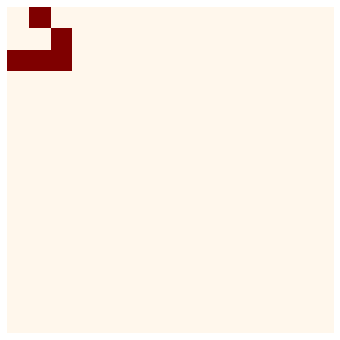

In [11]:
data = []
for i in range(epochs_num):
    f = open('save_life_' + str(i) + '.out')

    data_epoch = []
    for line in f:
        data_epoch.append(int(line))

    data.append(np.array(data_epoch))

data = np.array(data)

fig = plt.figure(figsize=(6, 6))
plt.axis('off')
im = plt.imshow(data[0].reshape((field_size, field_size)), 
                cmap=plt.cm.OrRd, interpolation='none')

In [12]:
ani = FuncAnimation(fig, animate, frames=len(data))

ani.save('glider.mp4')

HTML(ani.to_jshtml())

## Пример 2 Light-weight spaceship (LWSS)

In [13]:
epochs_num = 80
field_size = 30

In [14]:
%%writefile light-weight_spaceship.in
80
1
30 30
2 12
5 12
6 13
2 14
6 14
3 15
4 15
5 15
6 15

Overwriting light-weight_spaceship.in


In [15]:
!mpirun -n 4 --allow-run-as-root cellular_automata light-weight_spaceship.in

In [16]:
data = []
for i in range(epochs_num):
    f = open('save_life_' + str(i) + '.out')

    data_epoch = []
    for line in f:
        data_epoch.append(int(line))

    data.append(np.array(data_epoch))

data = np.array(data)

ani = FuncAnimation(fig, animate, frames=len(data))
ani.save('light-weight_spaceship.mp4')
HTML(ani.to_jshtml())

## Пример 3 Glider gun

In [17]:
epochs_num = 600
field_size = 60

In [18]:
%%writefile glider_gun.in
600
1
60 60
10 10
10 11
11 10
11 11
16 10
17 8
17 9
17 11
17 12
19 7
19 13
21 7
21 8
21 10
21 12
21 13
33 5
33 6
33 10
33 11
34 5
34 11
36 6
36 10
37 7
37 8
37 9
44 8
44 9
45 8
45 9

Overwriting glider_gun.in


In [19]:
!mpirun -n 4 --allow-run-as-root cellular_automata glider_gun.in

In [20]:
data = []
for i in range(epochs_num):
    f = open('save_life_' + str(i) + '.out')

    data_epoch = []
    for line in f:
        data_epoch.append(int(line))

    data.append(np.array(data_epoch))

data = np.array(data)

ani = FuncAnimation(fig, animate, frames=len(data))
ani.save('light-glider_gun.mp4')
HTML(ani.to_jshtml())

## Пример 4 Pulsar (period 3)

In [21]:
epochs_num = 9
field_size = 19

In [22]:
%%writefile pulsar.in
400
1
19 19
2 6
2 12
3 6
3 12
4 6
4 7
4 11
4 12
6 2
6 3
6 4
6 7
6 8
6 10
6 11
6 14
6 15
6 16
7 4
7 6
7 8
7 10
7 12
7 14
8 6
8 7
8 11
8 12
10 6
10 7
10 11
10 12
11 4
11 6
11 8
11 10
11 12
11 14
12 2
12 3
12 4
12 7
12 8
12 10
12 11
12 14
12 15
12 16
14 6
14 7
14 11
14 12
15 6
15 12
16 6
16 12

Overwriting pulsar.in


In [23]:
!mpirun -n 4 --allow-run-as-root cellular_automata pulsar.in

In [24]:
data = []
for i in range(epochs_num):
    f = open('save_life_' + str(i) + '.out')

    data_epoch = []
    for line in f:
        data_epoch.append(int(line))

    data.append(np.array(data_epoch))

data = np.array(data)

ani = FuncAnimation(fig, animate, frames=len(data))
ani.save('light-pulsar.mp4')
HTML(ani.to_jshtml())

## Построим графики зависимости скорости расчетов от числа потоков на примере 3 Glider gun

In [25]:
time_list = []
for i in range(2, 11, 1):
    time_temp = []
    for j in range(5):
        start_time = time.time()
        home = os.system("mpirun -n " + str(i) + " --allow-run-as-root cellular_automata glider_gun.in")
        time_temp.append(time.time() - start_time)
        # print("---Число потоков: " + str(i) + " ------ " + str(time_temp[-1]) + " seconds ---")
    time_list.append(np.array(time_temp).mean())

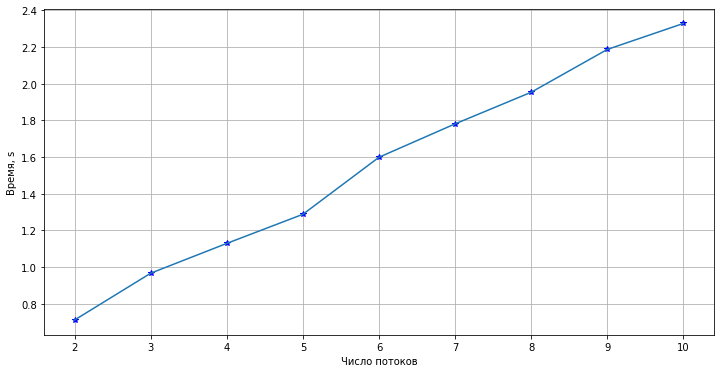

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(2, 11, 1), time_list, 'bo', marker='*')
plt.plot(np.arange(2, 11, 1), time_list)
plt.xlabel("Число потоков")
plt.ylabel("Время, s")
plt.grid(True)

plt.show()

#### Скорее всего график такой из-за того, что в colab всего 2 ядра, к тому же виртуальных. Поэтому зависимость получилась линейная